In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc, recall_score, f1_score
import time
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline

df = pd.read_csv('dengueSintomas.csv')
df.head()

,id_paciente,fecha_inicio_fiebre,dias_con_fiebre,temperatura_actual,globulos_blancos,dolor_cabeza_severo,dolor_detras_ojos,dolor_articular_muscular,sabor_metalico_boca,perdida_apetito,dolor_abdominal,nauseas_vomitos,diarrea,hemoglobina,hematocrito,plaquetas,dengue
0,P001,13-Jan,10.0,100.0,5.0,yes,no,no,yes,yes,yes,no,yes,15.0,21,140,yes
1,P002,13-Feb,4.0,104.0,1.0,no,yes,yes,no,no,no,no,no,9.0,22,80,no
2,P003,9-Jan,5.0,104.0,4.3,yes,no,no,yes,yes,yes,yes,no,9.3,24,120,yes
3,P004,12-Aug,12.0,101.0,1.8,yes,yes,no,no,no,no,no,no,11.2,25,50,no
4,P005,12-Oct,3.0,101.0,3.2,yes,no,no,no,no,no,yes,no,13.6,22,95,no


In [138]:
# Obtener información sobre las columnas y sus tipos de datos
df.info()

# Verificar la cantidad de valores nulos
df.isnull().sum()

# Ver estadísticas descriptivas
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1820 entries, 0 to 1819
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id_paciente               1820 non-null   object 
 1   fecha_inicio_fiebre       1820 non-null   object 
 2   dias_con_fiebre           1820 non-null   float64
 3   temperatura_actual        1820 non-null   float64
 4   globulos_blancos          1820 non-null   float64
 5   dolor_cabeza_severo       1820 non-null   object 
 6   dolor_detras_ojos         1820 non-null   object 
 7   dolor_articular_muscular  1820 non-null   object 
 8   sabor_metalico_boca       1820 non-null   object 
 9   perdida_apetito           1820 non-null   object 
 10  dolor_abdominal           1820 non-null   object 
 11  nauseas_vomitos           1820 non-null   object 
 12  diarrea                   1820 non-null   object 
 13  hemoglobina               1820 non-null   float64
 14  hematocr

,dias_con_fiebre,temperatura_actual,globulos_blancos,hemoglobina,hematocrito,plaquetas
count,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000
mean,6.432967,103.087912,3.025000,13.351786,32.080769,96.276374
std,3.601724,21.860645,1.272635,3.142119,7.385822,33.702430
min,1.000000,99.000000,1.000000,7.600000,18.000000,35.000000
25%,4.000000,102.000000,2.100000,10.600000,26.000000,74.000000
50%,6.000000,103.000000,2.950000,13.400000,32.000000,95.000000
75%,8.000000,104.000000,4.000000,15.900000,38.000000,120.000000
max,21.000000,1033.000000,24.000000,19.800000,47.000000,875.000000


In [139]:
# Convertir la columna de fecha en formato datetime
df['fecha_inicio_fiebre'] = pd.to_datetime(df['fecha_inicio_fiebre'], format='%d-%b')

# Convertir las columnas con valores binarios a tipo 'category'
columnas_categoricas = [
    'dolor_cabeza_severo', 'dolor_detras_ojos', 'dolor_articular_muscular', 
    'sabor_metalico_boca', 'perdida_apetito', 'dolor_abdominal', 
    'nauseas_vomitos', 'diarrea', 'dengue'
]

df[columnas_categoricas] = df[columnas_categoricas].astype('category')

df['dias_con_fiebre'] = df['dias_con_fiebre'].astype('int')

df.info()  
df.describe()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1820 entries, 0 to 1819
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id_paciente               1820 non-null   object        
 1   fecha_inicio_fiebre       1820 non-null   datetime64[ns]
 2   dias_con_fiebre           1820 non-null   int64         
 3   temperatura_actual        1820 non-null   float64       
 4   globulos_blancos          1820 non-null   float64       
 5   dolor_cabeza_severo       1820 non-null   category      
 6   dolor_detras_ojos         1820 non-null   category      
 7   dolor_articular_muscular  1820 non-null   category      
 8   sabor_metalico_boca       1820 non-null   category      
 9   perdida_apetito           1820 non-null   category      
 10  dolor_abdominal           1820 non-null   category      
 11  nauseas_vomitos           1820 non-null   category      
 12  diarrea             

,id_paciente,fecha_inicio_fiebre,dias_con_fiebre,temperatura_actual,globulos_blancos,dolor_cabeza_severo,dolor_detras_ojos,dolor_articular_muscular,sabor_metalico_boca,perdida_apetito,dolor_abdominal,nauseas_vomitos,diarrea,hemoglobina,hematocrito,plaquetas,dengue
0,P001,1900-01-13,10,100.0,5.0,yes,no,no,yes,yes,yes,no,yes,15.0,21,140,yes
1,P002,1900-02-13,4,104.0,1.0,no,yes,yes,no,no,no,no,no,9.0,22,80,no
2,P003,1900-01-09,5,104.0,4.3,yes,no,no,yes,yes,yes,yes,no,9.3,24,120,yes
3,P004,1900-08-12,12,101.0,1.8,yes,yes,no,no,no,no,no,no,11.2,25,50,no
4,P005,1900-10-12,3,101.0,3.2,yes,no,no,no,no,no,yes,no,13.6,22,95,no


# CONVERTIR COLUMNAS DE SINTOMAS A 1 Y 0

In [140]:
# Lista de columnas que contienen respuestas tipo "yes"/"no"
columnas_binarias = [
    'dolor_cabeza_severo',
    'dolor_detras_ojos',
    'dolor_articular_muscular',
    'sabor_metalico_boca',
    'perdida_apetito',
    'dolor_abdominal',
    'nauseas_vomitos',
    'diarrea',
    'dengue'
]

# Convertimos los valores: 'yes' -> 1 y 'no' -> 0
df[columnas_binarias] = df[columnas_binarias].replace({'yes': 1, 'no': 0})

# Verificamos los primeros registros de estas columnas para asegurarnos que la conversión fue correcta
df.head()

C:\Users\angel\AppData\Local\Temp\ipykernel_26664\3397136504.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columnas_binarias] = df[columnas_binarias].replace({'yes': 1, 'no': 0})
C:\Users\angel\AppData\Local\Temp\ipykernel_26664\3397136504.py:15: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df[columnas_binarias] = df[columnas_binarias].replace({'yes': 1, 'no': 0})
C:\Users\angel\AppData\Local\Temp\ipykernel_26664\3397136504.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To 

,id_paciente,fecha_inicio_fiebre,dias_con_fiebre,temperatura_actual,globulos_blancos,dolor_cabeza_severo,dolor_detras_ojos,dolor_articular_muscular,sabor_metalico_boca,perdida_apetito,dolor_abdominal,nauseas_vomitos,diarrea,hemoglobina,hematocrito,plaquetas,dengue
0,P001,1900-01-13,10,100.0,5.0,1,0,0,1,1,1,0,1,15.0,21,140,1
1,P002,1900-02-13,4,104.0,1.0,0,1,1,0,0,0,0,0,9.0,22,80,0
2,P003,1900-01-09,5,104.0,4.3,1,0,0,1,1,1,1,0,9.3,24,120,1
3,P004,1900-08-12,12,101.0,1.8,1,1,0,0,0,0,0,0,11.2,25,50,0
4,P005,1900-10-12,3,101.0,3.2,1,0,0,0,0,0,1,0,13.6,22,95,0


# TRATAMIENTO DE OUTLIERS

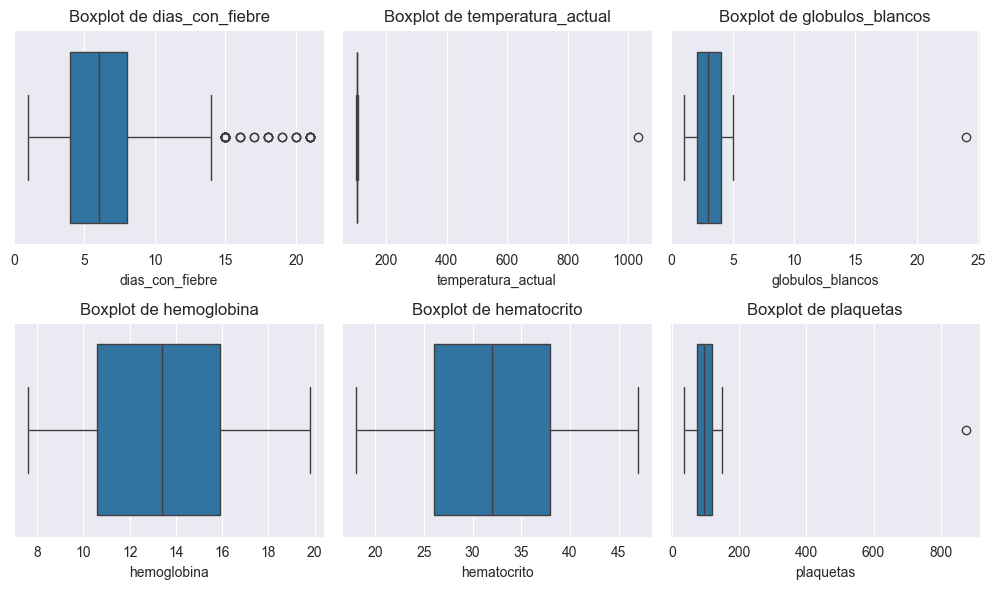

In [141]:
# Visualización de Outliers: Boxplots antes del tratamiento

# Columnas numéricas relevantes para el análisis
columnas_numericas = ['dias_con_fiebre', 'temperatura_actual', 'globulos_blancos', 
                      'hemoglobina', 'hematocrito', 'plaquetas']

# Crear un gráfico de caja (boxplot) para cada una de las columnas numéricas
plt.figure(figsize=(10, 6))
for i, columna in enumerate(columnas_numericas, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[columna])
    plt.title(f'Boxplot de {columna}')
    
plt.tight_layout()
plt.show()


In [142]:
# Imputar valores atípicos con la mediana
for columna in columnas_numericas:
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    df[columna] = np.where(df[columna] < limite_inferior, df[columna].median(), df[columna])
    df[columna] = np.where(df[columna] > limite_superior, df[columna].median(), df[columna])


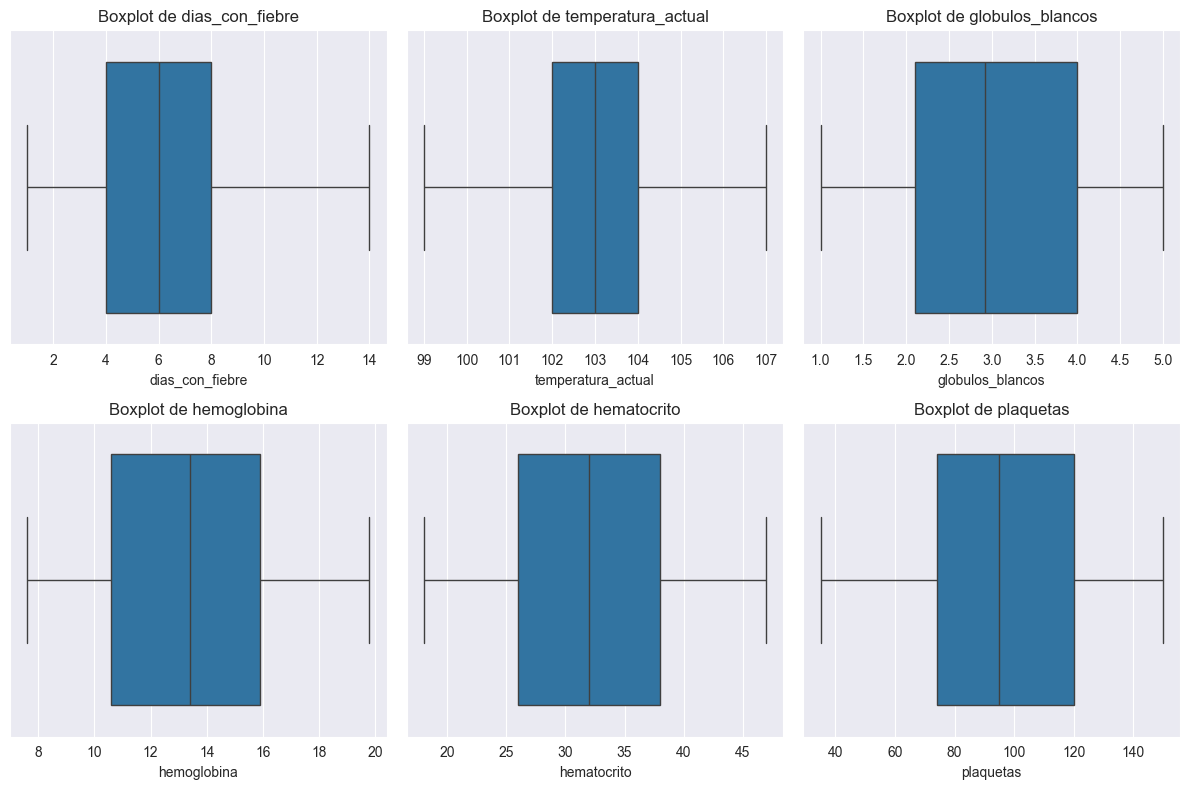

In [143]:
# Visualización de Outliers: Boxplots después del tratamiento

plt.figure(figsize=(12, 8))
for i, columna in enumerate(columnas_numericas, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[columna])
    plt.title(f'Boxplot de {columna}')
    
plt.tight_layout()
plt.show()


Distribución de la variable 'dolor_cabeza_severo':
dolor_cabeza_severo
1    1658
0     162
Name: count, dtype: int64
--------------------------------------------------
Distribución de la variable 'dolor_detras_ojos':
dolor_detras_ojos
0    1072
1     748
Name: count, dtype: int64
--------------------------------------------------
Distribución de la variable 'dolor_articular_muscular':
dolor_articular_muscular
0    1080
1     740
Name: count, dtype: int64
--------------------------------------------------
Distribución de la variable 'sabor_metalico_boca':
sabor_metalico_boca
0    1181
1     639
Name: count, dtype: int64
--------------------------------------------------
Distribución de la variable 'perdida_apetito':
perdida_apetito
0    1187
1     633
Name: count, dtype: int64
--------------------------------------------------
Distribución de la variable 'dolor_abdominal':
dolor_abdominal
0    984
1    836
Name: count, dtype: int64
--------------------------------------------------
Dist

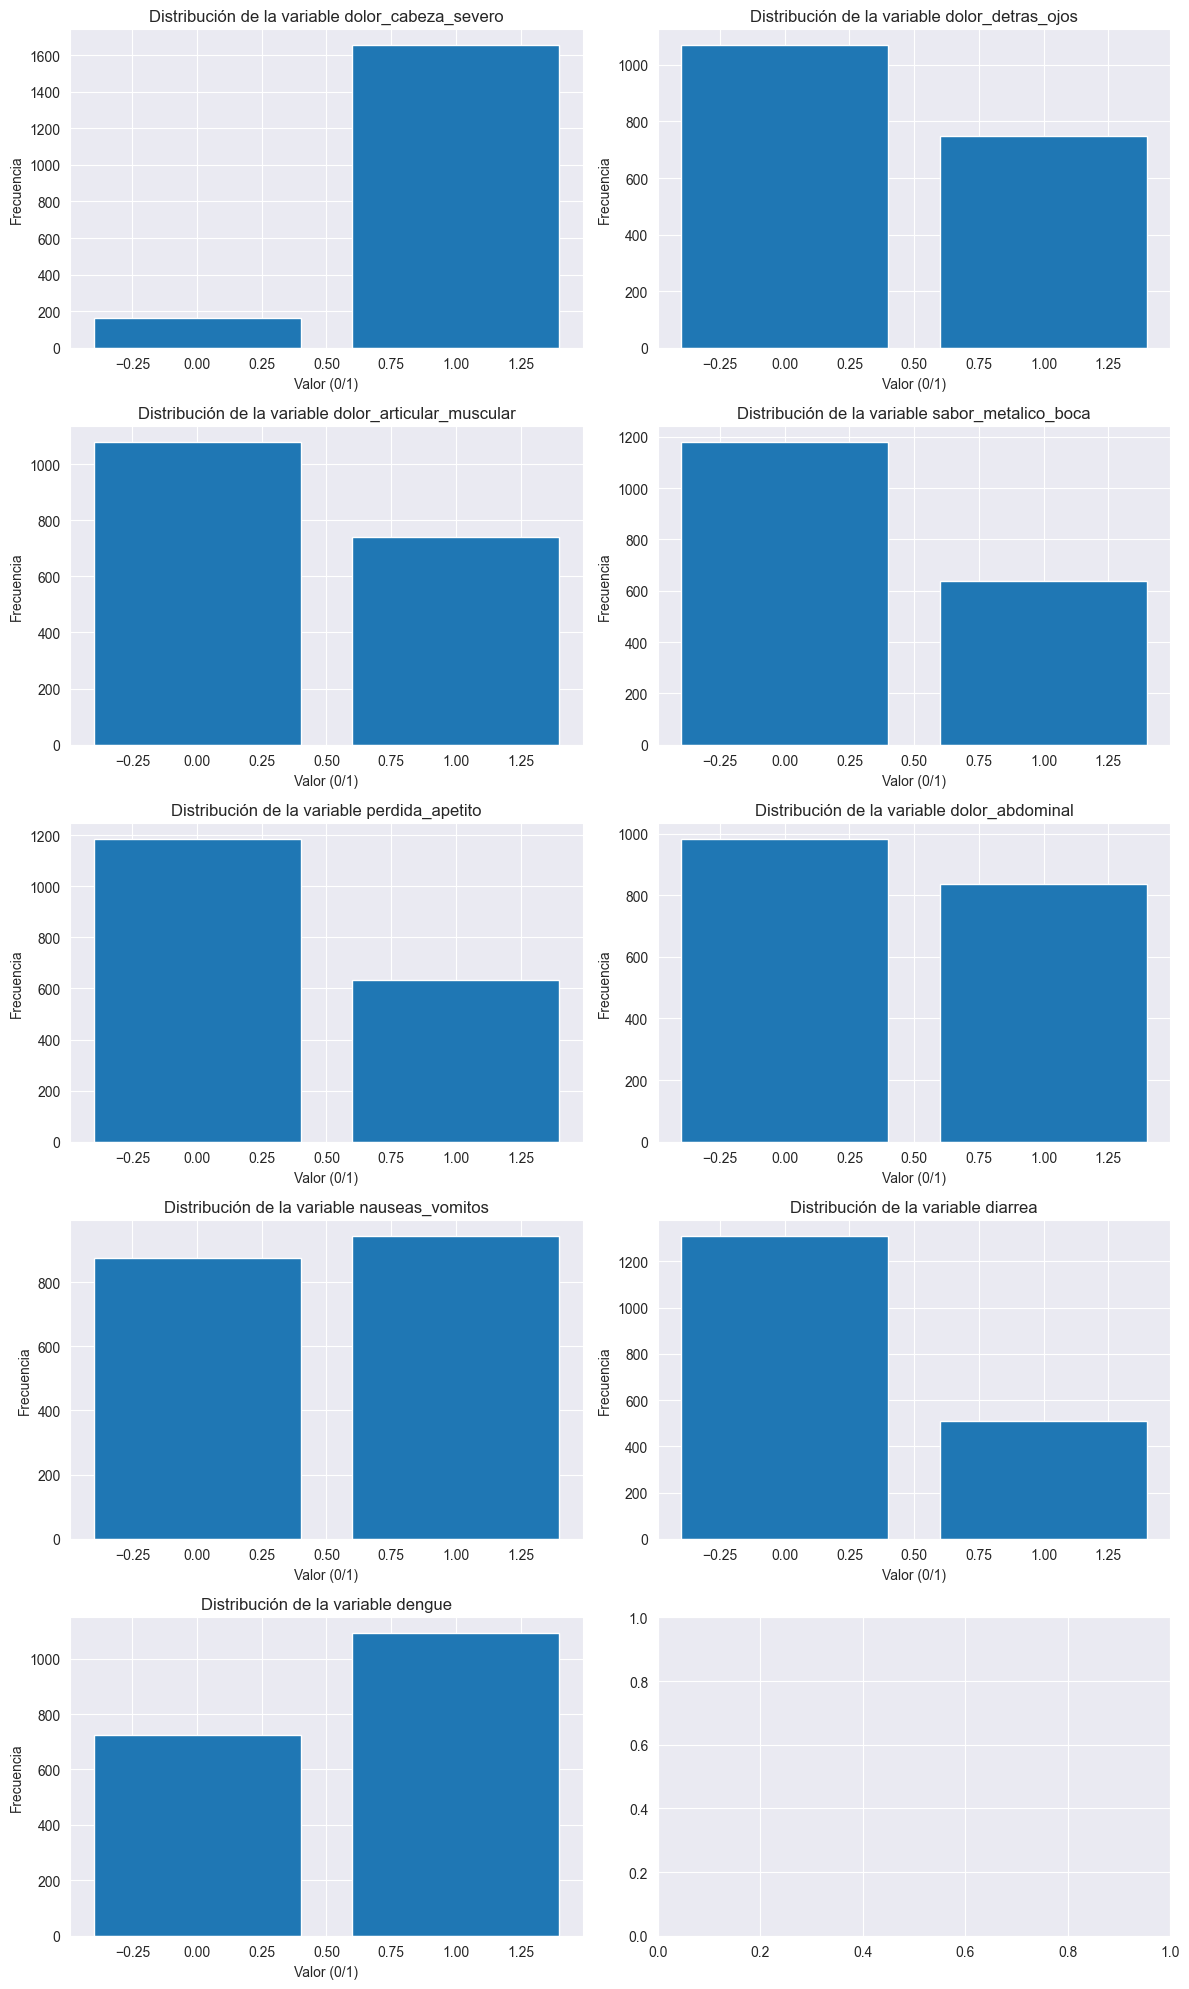

In [144]:
columnas = [
    'dolor_cabeza_severo', 'dolor_detras_ojos', 'dolor_articular_muscular',
    'sabor_metalico_boca', 'perdida_apetito', 'dolor_abdominal',
    'nauseas_vomitos', 'diarrea', 'dengue'
]

# Revisar la distribución de las clases (0/1) en cada columna
for col in columnas:
    print(f"Distribución de la variable '{col}':")
    print(df[col].value_counts())  # Cuenta la frecuencia de cada valor (0 y 1)
    print("-" * 50)

# Graficar la distribución de las clases para cada variable
num_cols = 2
num_rows = (len(columnas) + 1) // num_cols  # Redondear hacia arriba el número de filas

# Crear una figura con subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 4))

# Si hay un número impar de gráficos, hacer que el último subgráfico sea solo
axes = axes.flatten()

# Graficar la distribución de las clases en subgráficos
for i, col in enumerate(columnas):
    axes[i].bar(df[col].value_counts().index, df[col].value_counts().values)
    axes[i].set_title(f"Distribución de la variable {col}")
    axes[i].set_xlabel('Valor (0/1)')
    axes[i].set_ylabel('Frecuencia')

# Ajustar el layout para que no se superpongan los títulos
plt.tight_layout()
plt.show()

# MODELO SVM LINEAR



Resultados con Kernel: Lineal
Accuracy: 0.9753
AUC-ROC: 0.9917
Recall (Sensibilidad): 0.9631
Tiempo de predicción: 0.0036 segundos
Especificidad: 0.9932
Tasa de Falsos Positivos (FPR): 0.0068
F1-Score: 0.9789


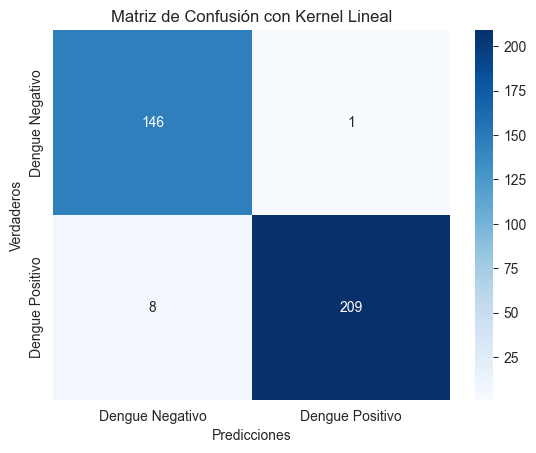

In [153]:

# Seleccionar las columnas numéricas y las columnas de síntomas
columnas_numericas = ['dias_con_fiebre']
columnas_no_numericas = ['dolor_cabeza_severo', 'dolor_detras_ojos', 'dolor_articular_muscular',
                          'sabor_metalico_boca', 'perdida_apetito', 'dolor_abdominal',
                          'nauseas_vomitos', 'diarrea']

# Convertir la variable objetivo (y) a valores numéricos
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['dengue'])

# X contiene las variables seleccionadas
X = df[columnas_no_numericas + ['dias_con_fiebre']]  # Agregamos 'dias_con_fiebre' junto con las no numéricas

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Usamos ColumnTransformer para aplicar transformaciones específicas a las columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), columnas_numericas),  # Estandarizar las columnas numéricas
        ('cat', OneHotEncoder(handle_unknown='ignore'), columnas_no_numericas)  # Usar OneHotEncoder
    ])

# Pipeline con preprocesamiento y modelo
pipeline_linear = Pipeline([
    ('preprocessor', preprocessor),  # Preprocesamiento de las columnas
    ('svm', SVC(kernel='linear', probability=True))  # Modelo SVM con kernel lineal
])

# Entrenar el modelo con el pipeline
pipeline_linear.fit(X_train, y_train)

# Hacer predicciones
y_pred_linear = pipeline_linear.predict(X_test)

# Evaluar el modelo
print("\nResultados con Kernel: Lineal")

# 1. Precisión (Accuracy)
accuracy_linear = accuracy_score(y_test, y_pred_linear)
print(f"Accuracy: {accuracy_linear:.4f}")

# 2. AUC-ROC
y_prob_linear = pipeline_linear.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva
fpr, tpr, thresholds = roc_curve(y_test, y_prob_linear)
roc_auc_linear = auc(fpr, tpr)
print(f"AUC-ROC: {roc_auc_linear:.4f}")

# 3. Sensibilidad (Recall)
recall_linear = recall_score(y_test, y_pred_linear)
print(f"Recall (Sensibilidad): {recall_linear:.4f}")

# 4. Tiempo de predicción
start_time = time.time()
y_pred_linear = pipeline_linear.predict(X_test)
end_time = time.time()
prediction_time_linear = end_time - start_time
print(f"Tiempo de predicción: {prediction_time_linear:.4f} segundos")

# 5. Especificidad (Specificity)
cm = confusion_matrix(y_test, y_pred_linear)
tn, fp, fn, tp = cm.ravel()
specificity_linear = tn / (tn + fp)
print(f"Especificidad: {specificity_linear:.4f}")

# 6. Tasa de Falsos Positivos (FPR)
fpr_linear = fp / (tn + fp)
print(f"Tasa de Falsos Positivos (FPR): {fpr_linear:.4f}")

# 7. F1-Score
f1_linear = f1_score(y_test, y_pred_linear)
print(f"F1-Score: {f1_linear:.4f}")

# Crear la matriz de confusión
cm_linear = confusion_matrix(y_test, y_pred_linear)

# Graficar la matriz de confusión
sns.heatmap(cm_linear, annot=True, fmt='d', cmap='Blues', xticklabels=['Dengue Negativo', 'Dengue Positivo'], yticklabels=['Dengue Negativo', 'Dengue Positivo'])
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')
plt.title('Matriz de Confusión con Kernel Lineal')
plt.show()

# MODELO SVM POLINÓMICO



Resultados con Kernel: Polinómico
Accuracy: 0.9918
AUC-ROC: 0.9990
Recall (Sensibilidad): 1.0000
Tiempo de predicción: 0.0027 segundos
Especificidad: 0.9796
Tasa de Falsos Positivos (FPR): 0.0204
F1-Score: 0.9931


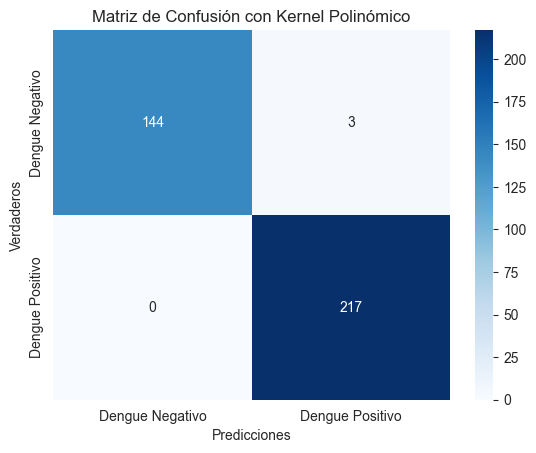

In [155]:
# Seleccionar las columnas numéricas y las columnas no numéricas
columnas_numericas = ['dias_con_fiebre']

columnas_no_numericas = ['dolor_cabeza_severo', 'dolor_detras_ojos', 'dolor_articular_muscular',
                          'sabor_metalico_boca', 'perdida_apetito', 'dolor_abdominal',
                          'nauseas_vomitos', 'diarrea']

# X contiene las variables seleccionadas
X = df[columnas_no_numericas + ['dias_con_fiebre']]  # Agregamos 'dias_con_fiebre' junto con las no numéricas
y = df['dengue']  # Variable objetivo: dengue

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Usamos ColumnTransformer para aplicar transformaciones específicas a las columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), columnas_numericas),  # Estandarizar las columnas numéricas
        ('cat', OrdinalEncoder(), columnas_no_numericas)
    ])

# Pipeline con preprocesamiento y modelo
pipeline_poly = Pipeline([
    ('preprocessor', preprocessor),  # Preprocesamiento de las columnas
    ('svm', SVC(kernel='poly', probability=True))  # Modelo SVM con kernel polinómico
])

# Entrenar el modelo con el pipeline
pipeline_poly.fit(X_train, y_train)

# Hacer predicciones
y_pred_poly = pipeline_poly.predict(X_test)

# Evaluar el modelo
print("\nResultados con Kernel: Polinómico")

# 1. Precisión (Accuracy)
accuracy_poly = accuracy_score(y_test, y_pred_poly)
print(f"Accuracy: {accuracy_poly:.4f}")

# 2. AUC-ROC
y_prob_poly = pipeline_poly.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva
fpr, tpr, thresholds = roc_curve(y_test, y_prob_poly)
roc_auc_poly = auc(fpr, tpr)
print(f"AUC-ROC: {roc_auc_poly:.4f}")

# 3. Sensibilidad (Recall)
recall_poly = recall_score(y_test, y_pred_poly)
print(f"Recall (Sensibilidad): {recall_poly:.4f}")

# 4. Tiempo de predicción
start_time = time.time()
y_pred_poly = pipeline_poly.predict(X_test)
end_time = time.time()
prediction_time_poly = end_time - start_time
print(f"Tiempo de predicción: {prediction_time_poly:.4f} segundos")

# 5. Especificidad (Specificity)
cm = confusion_matrix(y_test, y_pred_poly)
tn, fp, fn, tp = cm.ravel()
specificity_poly = tn / (tn + fp)
print(f"Especificidad: {specificity_poly:.4f}")

# 6. Tasa de Falsos Positivos (FPR)
fpr_poly = fp / (tn + fp)
print(f"Tasa de Falsos Positivos (FPR): {fpr_poly:.4f}")

# 7. F1-Score
f1_poly = f1_score(y_test, y_pred_poly)
print(f"F1-Score: {f1_poly:.4f}")

# Crear la matriz de confusión
cm_poly = confusion_matrix(y_test, y_pred_poly)

# Graficar la matriz de confusión
sns.heatmap(cm_poly, annot=True, fmt='d', cmap='Blues', xticklabels=['Dengue Negativo', 'Dengue Positivo'], yticklabels=['Dengue Negativo', 'Dengue Positivo'])
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')
plt.title('Matriz de Confusión con Kernel Polinómico')
plt.show()

# MODELO SVM RBF


Resultados con Kernel: RBF
Accuracy: 0.9725
AUC-ROC: 0.9991
Recall (Sensibilidad): 0.9631
Tiempo de predicción: 0.0084 segundos
Especificidad: 0.9864
Tasa de Falsos Positivos (FPR): 0.0136
F1-Score: 0.9766


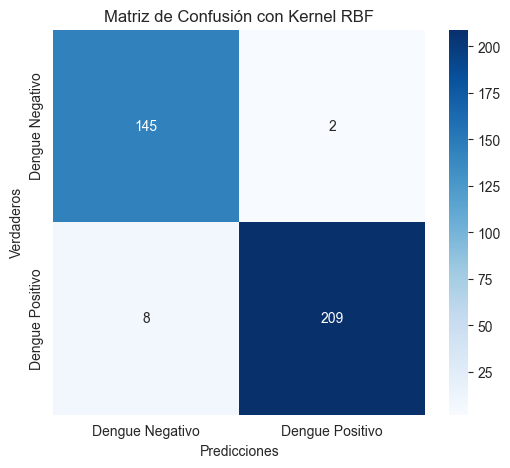

In [148]:
# Seleccionar las columnas numéricas y no numéricas
columnas_numericas = ['dias_con_fiebre']

columnas_no_numericas = ['dolor_cabeza_severo', 'dolor_detras_ojos', 'dolor_articular_muscular',
                          'sabor_metalico_boca', 'perdida_apetito', 'dolor_abdominal',
                          'nauseas_vomitos', 'diarrea']

# X contiene solo las variables seleccionadas
X = df[columnas_no_numericas + ['dias_con_fiebre']]  # Agregamos 'dias_con_fiebre' junto con las no numéricas
y = df['dengue']  # Variable objetivo: dengue

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Usamos ColumnTransformer para aplicar transformaciones específicas a las columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), columnas_numericas),  # Estandarizar las columnas numéricas
        ('cat', OrdinalEncoder(), columnas_no_numericas)
    ])

# Pipeline con preprocesamiento y modelo
pipeline_rbf = Pipeline([
    ('preprocessor', preprocessor),  # Preprocesamiento de las columnas
    ('svm', SVC(kernel='rbf', probability=True))  # Modelo SVM con kernel RBF
])

# Entrenar el modelo con el pipeline
pipeline_rbf.fit(X_train, y_train)

# Hacer predicciones
y_pred_rbf = pipeline_rbf.predict(X_test)

# Evaluar el modelo
print("\nResultados con Kernel: RBF")

# 1. Precisión (Accuracy)
accuracy_rbf = accuracy_score(y_test, y_pred_rbf)
print(f"Accuracy: {accuracy_rbf:.4f}")

# 2. AUC-ROC
y_prob_rbf = pipeline_rbf.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva
fpr, tpr, thresholds = roc_curve(y_test, y_prob_rbf)
roc_auc_rbf = auc(fpr, tpr)
print(f"AUC-ROC: {roc_auc_rbf:.4f}")

# 3. Sensibilidad (Recall)
recall_rbf = recall_score(y_test, y_pred_rbf)
print(f"Recall (Sensibilidad): {recall_rbf:.4f}")

# 4. Tiempo de predicción
start_time = time.time()
y_pred_rbf = pipeline_rbf.predict(X_test)
end_time = time.time()
prediction_time_rbf = end_time - start_time
print(f"Tiempo de predicción: {prediction_time_rbf:.4f} segundos")

# 5. Especificidad (Specificity)
cm_rbf = confusion_matrix(y_test, y_pred_rbf)
tn, fp, fn, tp = cm_rbf.ravel()
specificity_rbf = tn / (tn + fp)
print(f"Especificidad: {specificity_rbf:.4f}")

# 6. Tasa de Falsos Positivos (FPR)
fpr_rbf = fp / (tn + fp)
print(f"Tasa de Falsos Positivos (FPR): {fpr_rbf:.4f}")

# 7. F1-Score
f1_rbf = f1_score(y_test, y_pred_rbf)
print(f"F1-Score: {f1_rbf:.4f}")

# Crear la matriz de confusión
cm_rbf = confusion_matrix(y_test, y_pred_rbf)

# Graficar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rbf, annot=True, fmt='d', cmap='Blues', xticklabels=['Dengue Negativo', 'Dengue Positivo'], yticklabels=['Dengue Negativo', 'Dengue Positivo'])
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')
plt.title('Matriz de Confusión con Kernel RBF')
plt.show()

# MODELO SVM SIGMOIDE


Resultados con Kernel: Sigmoide
Accuracy: 0.8379
AUC-ROC: 0.9085
Recall (Sensibilidad): 0.8664
Tiempo de predicción: 0.0078 segundos
Especificidad: 0.7959
Tasa de Falsos Positivos (FPR): 0.2041
F1-Score: 0.8644


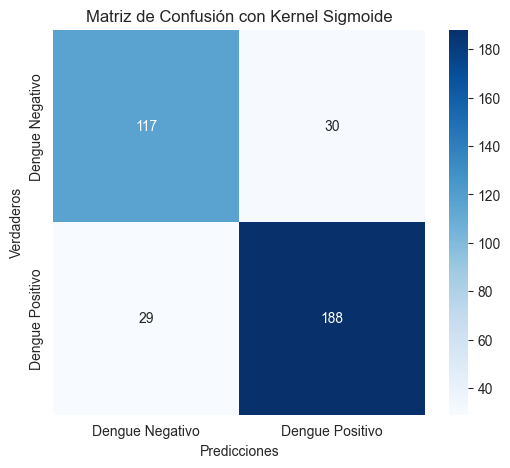

In [149]:
# Seleccionar las columnas numéricas y no numéricas
columnas_numericas = ['dias_con_fiebre']

columnas_no_numericas = ['dolor_cabeza_severo', 'dolor_detras_ojos', 'dolor_articular_muscular',
                          'sabor_metalico_boca', 'perdida_apetito', 'dolor_abdominal',
                          'nauseas_vomitos', 'diarrea']

# X contiene solo las variables seleccionadas
X = df[columnas_no_numericas + ['dias_con_fiebre']]  # Agregamos 'dias_con_fiebre' junto con las no numéricas
y = df['dengue']  # Variable objetivo: dengue

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Usamos ColumnTransformer para aplicar transformaciones específicas a las columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), columnas_numericas),  # Estandarizar las columnas numéricas
        ('cat', OrdinalEncoder(), columnas_no_numericas)
    ])

# Pipeline con preprocesamiento y modelo
pipeline_sigmoid = Pipeline([
    ('preprocessor', preprocessor),  # Preprocesamiento de las columnas
    ('svm', SVC(kernel='sigmoid', probability=True))  # Modelo SVM con kernel Sigmoide
])

# Entrenar el modelo con el pipeline
pipeline_sigmoid.fit(X_train, y_train)

# Hacer predicciones
y_pred_sigmoid = pipeline_sigmoid.predict(X_test)

# Evaluar el modelo
print("\nResultados con Kernel: Sigmoide")

# 1. Precisión (Accuracy)
accuracy_sigmoid = accuracy_score(y_test, y_pred_sigmoid)
print(f"Accuracy: {accuracy_sigmoid:.4f}")

# 2. AUC-ROC
y_prob_sigmoid = pipeline_sigmoid.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva
fpr, tpr, thresholds = roc_curve(y_test, y_prob_sigmoid)
roc_auc_sigmoid = auc(fpr, tpr)
print(f"AUC-ROC: {roc_auc_sigmoid:.4f}")

# 3. Sensibilidad (Recall)
recall_sigmoid = recall_score(y_test, y_pred_sigmoid)
print(f"Recall (Sensibilidad): {recall_sigmoid:.4f}")

# 4. Tiempo de predicción
start_time = time.time()
y_pred_sigmoid = pipeline_sigmoid.predict(X_test)
end_time = time.time()
prediction_time_sigmoid = end_time - start_time
print(f"Tiempo de predicción: {prediction_time_sigmoid:.4f} segundos")

# 5. Especificidad (Specificity)
cm_sigmoid = confusion_matrix(y_test, y_pred_sigmoid)
tn, fp, fn, tp = cm_sigmoid.ravel()
specificity_sigmoid = tn / (tn + fp)
print(f"Especificidad: {specificity_sigmoid:.4f}")

# 6. Tasa de Falsos Positivos (FPR)
fpr_sigmoid = fp / (tn + fp)
print(f"Tasa de Falsos Positivos (FPR): {fpr_sigmoid:.4f}")

# 7. F1-Score
f1_sigmoid = f1_score(y_test, y_pred_sigmoid)
print(f"F1-Score: {f1_sigmoid:.4f}")

# Crear la matriz de confusión
cm_sigmoid = confusion_matrix(y_test, y_pred_sigmoid)

# Graficar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm_sigmoid, annot=True, fmt='d', cmap='Blues', xticklabels=['Dengue Negativo', 'Dengue Positivo'], yticklabels=['Dengue Negativo', 'Dengue Positivo'])
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')
plt.title('Matriz de Confusión con Kernel Sigmoide')
plt.show()

In [150]:
def convertir_riesgo(prob):
    if prob < 0.3:
        return 'bajo'
    elif prob < 0.7:
        return 'medio'
    else:
        return 'alto'

# Convertir las probabilidades en categorías de riesgo para cada modelo
riesgo_linear = [convertir_riesgo(p) for p in y_prob_linear]
riesgo_poly = [convertir_riesgo(p) for p in y_prob_poly]
riesgo_rbf = [convertir_riesgo(p) for p in y_prob_rbf]
riesgo_sigmoid = [convertir_riesgo(p) for p in y_prob_sigmoid]

In [151]:
import joblib
# Guardar el modelo con kernel lineal
joblib.dump(pipeline_linear, 'modelo_svm_lineal_ajustado.pkl')
# Guardar el modelo con kernel polinómico
joblib.dump(pipeline_poly, 'modelo_svm_poli_ajustado.pkl')
# Guardar el modelo con kernel RBF
joblib.dump(pipeline_rbf, 'modelo_svm_rbf_ajustado.pkl')
# Guardar el modelo con kernel sigmoide
joblib.dump(pipeline_sigmoid, 'modelo_svm_sigmoide_ajustado.pkl')

['modelo_svm_sigmoide_ajustado.pkl']

# MODELO LINEAR CON PARAMETROS AJUSTADOS

Mejores parámetros (Kernel Lineal): {'C': 1, 'gamma': 'auto'}
Resultados con Kernel Lineal Ajustado
Accuracy: 0.9780
AUC-ROC: 0.9979
Recall (Sensibilidad): 0.9631
Tiempo de predicción: 0.0077 segundos
Especificidad: 1.0000
Tasa de Falsos Positivos (FPR): 0.0000
F1-Score: 0.9812


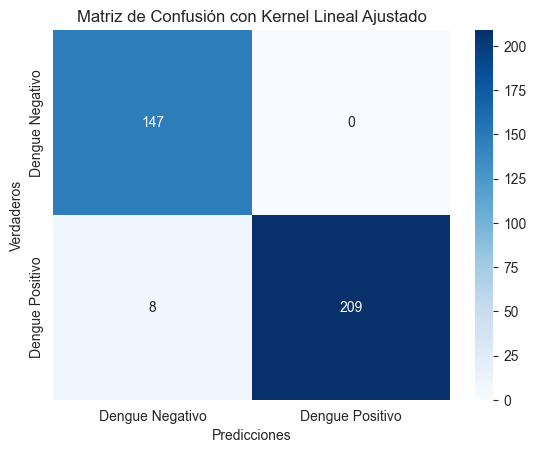

In [43]:
# Seleccionar las columnas numéricas
columnas_numericas = ['dias_con_fiebre', 'temperatura_actual', 'globulos_blancos',
                       'hemoglobina', 'hematocrito', 'plaquetas']

# Seleccionar las columnas no numéricas
columnas_no_numericas = ['dolor_cabeza_severo', 'dolor_detras_ojos', 'dolor_articular_muscular',
                          'sabor_metalico_boca', 'perdida_apetito', 'dolor_abdominal',
                          'nauseas_vomitos', 'diarrea']

# Estandarización de las columnas numéricas
scaler = StandardScaler()
df[columnas_numericas] = scaler.fit_transform(df[columnas_numericas])  # Solo estandariza las columnas numéricas

# X contiene solo las variables seleccionadas
X = df[columnas_no_numericas + ['dias_con_fiebre']]  # Agregamos 'dias_con_fiebre' junto con las no numéricas
y = df['dengue']  # Variable objetivo: dengue

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir los parámetros a ajustar
param_grid_linear = {
    'C': [0.1, 1, 10],  # Parámetro de regularización
    'gamma': ['scale', 'auto']  # Parámetro gamma para el kernel lineal
}

# Crear el modelo SVM
svm_linear = SVC(probability=True)

# Realizar búsqueda en cuadrícula para el modelo ajustado
grid_search_linear = GridSearchCV(svm_linear, param_grid_linear, cv=5, scoring='accuracy')
grid_search_linear.fit(X_train, y_train)

# Mejor parámetro
print(f"Mejores parámetros (Kernel Lineal): {grid_search_linear.best_params_}")
best_svm_linear = grid_search_linear.best_estimator_

# Hacer predicciones con el modelo ajustado
y_pred_linear_adjusted = best_svm_linear.predict(X_test)

# Evaluar el modelo ajustado
print("Resultados con Kernel Lineal Ajustado")

# 1. Precisión (Accuracy)
accuracy_linear_adjusted = accuracy_score(y_test, y_pred_linear_adjusted)
print(f"Accuracy: {accuracy_linear_adjusted:.4f}")

# 2. AUC-ROC
y_prob_adjusted = best_svm_linear.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva
fpr_adjusted, tpr_adjusted, thresholds_adjusted = roc_curve(y_test, y_prob_adjusted)
roc_auc_linear_adjusted = auc(fpr_adjusted, tpr_adjusted)
print(f"AUC-ROC: {roc_auc_linear_adjusted:.4f}")

# 3. Sensibilidad (Recall)
recall_linear_adjusted = recall_score(y_test, y_pred_linear_adjusted)
print(f"Recall (Sensibilidad): {recall_linear_adjusted:.4f}")

# 4. Tiempo de predicción
start_time = time.time()
y_pred_linear_adjusted = best_svm_linear.predict(X_test)
end_time = time.time()
prediction_time_linear_adjusted = end_time - start_time
print(f"Tiempo de predicción: {prediction_time_linear_adjusted:.4f} segundos")

# 5. Especificidad (Specificity)
cm_adjusted = confusion_matrix(y_test, y_pred_linear_adjusted)
tn_adjusted, fp_adjusted, fn_adjusted, tp_adjusted = cm_adjusted.ravel()
specificity_linear_adjusted = tn_adjusted / (tn_adjusted + fp_adjusted)
print(f"Especificidad: {specificity_linear_adjusted:.4f}")

# 6. Tasa de Falsos Positivos (FPR)
fpr_linear_adjusted = fp_adjusted / (tn_adjusted + fp_adjusted)
print(f"Tasa de Falsos Positivos (FPR): {fpr_linear_adjusted:.4f}")

# 7. F1-Score
f1_linear_adjusted = f1_score(y_test, y_pred_linear_adjusted)
print(f"F1-Score: {f1_linear_adjusted:.4f}")

# Crear la matriz de confusión
cm_adjusted = confusion_matrix(y_test, y_pred_linear_adjusted)

# Graficar la matriz de confusión ajustada
sns.heatmap(cm_adjusted, annot=True, fmt='d', cmap='Blues', xticklabels=['Dengue Negativo', 'Dengue Positivo'], yticklabels=['Dengue Negativo', 'Dengue Positivo'])
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')
plt.title('Matriz de Confusión con Kernel Lineal Ajustado')
plt.show()


# MODELO POLINÓMICO CON PARAMETROS AJUSTADOS

Mejores parámetros (Kernel Polinómico): {'C': 1, 'degree': 2, 'gamma': 'auto'}
Resultados con Kernel Polinómico Ajustado
Accuracy: 0.9780
AUC-ROC: 0.9979
Recall (Sensibilidad): 0.9631
Tiempo de predicción: 0.0080 segundos
Especificidad: 1.0000
Tasa de Falsos Positivos (FPR): 0.0000
F1-Score: 0.9812


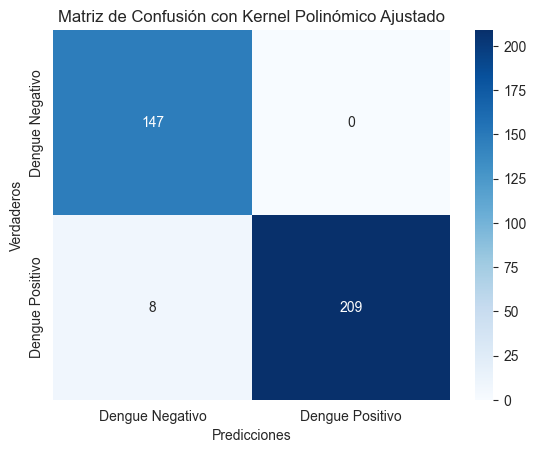

In [44]:
# Seleccionar las columnas numéricas
columnas_numericas = ['dias_con_fiebre', 'temperatura_actual', 'globulos_blancos',
                       'hemoglobina', 'hematocrito', 'plaquetas']

# Seleccionar las columnas no numéricas
columnas_no_numericas = ['dolor_cabeza_severo', 'dolor_detras_ojos', 'dolor_articular_muscular',
                          'sabor_metalico_boca', 'perdida_apetito', 'dolor_abdominal',
                          'nauseas_vomitos', 'diarrea']

# Estandarización de las columnas numéricas
scaler = StandardScaler()
df[columnas_numericas] = scaler.fit_transform(df[columnas_numericas])  # Solo estandariza las columnas numéricas

# X contiene solo las variables seleccionadas
X = df[columnas_no_numericas + ['dias_con_fiebre']]  # Agregamos 'dias_con_fiebre' junto con las no numéricas
y = df['dengue']  # Variable objetivo: dengue

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir los parámetros a ajustar para el modelo Polinómico
param_grid_poly = {
    'C': [0.1, 1, 10],  # Parámetro de regularización
    'degree': [2, 3, 4],  # Grado del polinomio
    'gamma': ['scale', 'auto']  # Parámetro gamma para el kernel polinómico
}

# Crear el modelo SVM
svm_poly = SVC(probability=True)

# Realizar búsqueda en cuadrícula para el modelo ajustado
grid_search_poly = GridSearchCV(svm_poly, param_grid_poly, cv=5, scoring='accuracy')
grid_search_poly.fit(X_train, y_train)

# Mejor parámetro
print(f"Mejores parámetros (Kernel Polinómico): {grid_search_poly.best_params_}")
best_svm_poly = grid_search_poly.best_estimator_

# Hacer predicciones con el modelo ajustado
y_pred_poly_adjusted = best_svm_poly.predict(X_test)

# Evaluar el modelo ajustado
print("Resultados con Kernel Polinómico Ajustado")
# 1. Precisión (Accuracy)
accuracy_poly_adjusted = accuracy_score(y_test, y_pred_poly_adjusted)
print(f"Accuracy: {accuracy_poly_adjusted:.4f}")

# 2. AUC-ROC
y_prob_poly_adjusted = best_svm_poly.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva
fpr_poly_adjusted, tpr_poly_adjusted, thresholds_poly_adjusted = roc_curve(y_test, y_prob_poly_adjusted)
roc_auc_poly_adjusted = auc(fpr_poly_adjusted, tpr_poly_adjusted)
print(f"AUC-ROC: {roc_auc_poly_adjusted:.4f}")

# 3. Sensibilidad (Recall)
recall_poly_adjusted = recall_score(y_test, y_pred_poly_adjusted)
print(f"Recall (Sensibilidad): {recall_poly_adjusted:.4f}")

# 4. Tiempo de predicción
start_time_poly = time.time()
y_pred_poly_adjusted = best_svm_poly.predict(X_test)
end_time_poly = time.time()
prediction_time_poly_adjusted = end_time_poly - start_time_poly
print(f"Tiempo de predicción: {prediction_time_poly_adjusted:.4f} segundos")

# 5. Especificidad (Specificity)
cm_poly_adjusted = confusion_matrix(y_test, y_pred_poly_adjusted)
tn_poly_adjusted, fp_poly_adjusted, fn_poly_adjusted, tp_poly_adjusted = cm_poly_adjusted.ravel()
specificity_poly_adjusted = tn_poly_adjusted / (tn_poly_adjusted + fp_poly_adjusted)
print(f"Especificidad: {specificity_poly_adjusted:.4f}")

# 6. Tasa de Falsos Positivos (FPR)
fpr_poly_adjusted = fp_poly_adjusted / (tn_poly_adjusted + fp_poly_adjusted)
print(f"Tasa de Falsos Positivos (FPR): {fpr_poly_adjusted:.4f}")

# 7. F1-Score
f1_poly_adjusted = f1_score(y_test, y_pred_poly_adjusted)
print(f"F1-Score: {f1_poly_adjusted:.4f}")

# Crear la matriz de confusión
cm_poly_adjusted = confusion_matrix(y_test, y_pred_poly_adjusted)

# Graficar la matriz de confusión ajustada
sns.heatmap(cm_poly_adjusted, annot=True, fmt='d', cmap='Blues', xticklabels=['Dengue Negativo', 'Dengue Positivo'], yticklabels=['Dengue Negativo', 'Dengue Positivo'])
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')
plt.title('Matriz de Confusión con Kernel Polinómico Ajustado')
plt.show()

# MODELO RBF CON PARAMETROS AJUSTADOS

Mejores parámetros (Kernel RBF): {'C': 1, 'gamma': 'auto'}
Resultados con Kernel RBF Ajustado
Accuracy: 0.9780
AUC-ROC: 0.9979
Recall (Sensibilidad): 0.9631
Tiempo de predicción: 0.0101 segundos
Especificidad: 1.0000
Tasa de Falsos Positivos (FPR): 0.0000
F1-Score: 0.9812


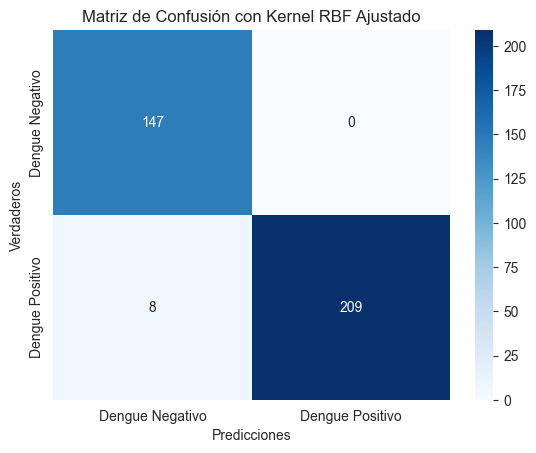

In [45]:
# Seleccionar las columnas numéricas
columnas_numericas = ['dias_con_fiebre', 'temperatura_actual', 'globulos_blancos',
                       'hemoglobina', 'hematocrito', 'plaquetas']

# Seleccionar las columnas no numéricas
columnas_no_numericas = ['dolor_cabeza_severo', 'dolor_detras_ojos', 'dolor_articular_muscular',
                          'sabor_metalico_boca', 'perdida_apetito', 'dolor_abdominal',
                          'nauseas_vomitos', 'diarrea']

# Estandarización de las columnas numéricas
scaler = StandardScaler()
df[columnas_numericas] = scaler.fit_transform(df[columnas_numericas])  # Solo estandariza las columnas numéricas

# X contiene solo las variables seleccionadas
X = df[columnas_no_numericas + ['dias_con_fiebre']]  # Agregamos 'dias_con_fiebre' junto con las no numéricas
y = df['dengue']  # Variable objetivo: dengue

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir los parámetros a ajustar para el modelo RBF
param_grid_rbf = {
    'C': [0.1, 1, 10],  # Parámetro de regularización
    'gamma': ['scale', 'auto']  # Parámetro gamma para el kernel RBF
}

# Crear el modelo SVM
svm_rbf = SVC(probability=True)

# Realizar búsqueda en cuadrícula para el modelo ajustado
grid_search_rbf = GridSearchCV(svm_rbf, param_grid_rbf, cv=5, scoring='accuracy')
grid_search_rbf.fit(X_train, y_train)

# Mejor parámetro
print(f"Mejores parámetros (Kernel RBF): {grid_search_rbf.best_params_}")
best_svm_rbf = grid_search_rbf.best_estimator_

# Hacer predicciones con el modelo ajustado
y_pred_rbf_adjusted = best_svm_rbf.predict(X_test)

# Evaluar el modelo ajustado
print("Resultados con Kernel RBF Ajustado")
# 1. Precisión (Accuracy)
accuracy_rbf_adjusted = accuracy_score(y_test, y_pred_rbf_adjusted)
print(f"Accuracy: {accuracy_rbf_adjusted:.4f}")

# 2. AUC-ROC
y_prob_rbf_adjusted = best_svm_rbf.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva
fpr_rbf_adjusted, tpr_rbf_adjusted, thresholds_rbf_adjusted = roc_curve(y_test, y_prob_rbf_adjusted)
roc_auc_rbf_adjusted = auc(fpr_rbf_adjusted, tpr_rbf_adjusted)
print(f"AUC-ROC: {roc_auc_rbf_adjusted:.4f}")

# 3. Sensibilidad (Recall)
recall_rbf_adjusted = recall_score(y_test, y_pred_rbf_adjusted)
print(f"Recall (Sensibilidad): {recall_rbf_adjusted:.4f}")

# 4. Tiempo de predicción
start_time_rbf = time.time()
y_pred_rbf_adjusted = best_svm_rbf.predict(X_test)
end_time_rbf = time.time()
prediction_time_rbf_adjusted = end_time_rbf - start_time_rbf
print(f"Tiempo de predicción: {prediction_time_rbf_adjusted:.4f} segundos")

# 5. Especificidad (Specificity)
cm_rbf_adjusted = confusion_matrix(y_test, y_pred_rbf_adjusted)
tn_rbf_adjusted, fp_rbf_adjusted, fn_rbf_adjusted, tp_rbf_adjusted = cm_rbf_adjusted.ravel()
specificity_rbf_adjusted = tn_rbf_adjusted / (tn_rbf_adjusted + fp_rbf_adjusted)
print(f"Especificidad: {specificity_rbf_adjusted:.4f}")

# 6. Tasa de Falsos Positivos (FPR)
fpr_rbf_adjusted = fp_rbf_adjusted / (tn_rbf_adjusted + fp_rbf_adjusted)
print(f"Tasa de Falsos Positivos (FPR): {fpr_rbf_adjusted:.4f}")

# 7. F1-Score
f1_rbf_adjusted = f1_score(y_test, y_pred_rbf_adjusted)
print(f"F1-Score: {f1_rbf_adjusted:.4f}")

# Crear la matriz de confusión
cm_rbf_adjusted = confusion_matrix(y_test, y_pred_rbf_adjusted)

# Graficar la matriz de confusión ajustada
sns.heatmap(cm_rbf_adjusted, annot=True, fmt='d', cmap='Blues', xticklabels=['Dengue Negativo', 'Dengue Positivo'], yticklabels=['Dengue Negativo', 'Dengue Positivo'])
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')
plt.title('Matriz de Confusión con Kernel RBF Ajustado')
plt.show()

# MODELO SIGMOIDE CON PARAMETROS AJUSTADOS

Mejores parámetros (Kernel Sigmoide): {'C': 1, 'gamma': 'auto'}
Resultados con Kernel Sigmoide Ajustado
Accuracy: 0.9780
AUC-ROC: 0.9979
Recall (Sensibilidad): 0.9631
Tiempo de predicción: 0.0088 segundos
Especificidad: 1.0000
Tasa de Falsos Positivos (FPR): 0.0000
F1-Score: 0.9812


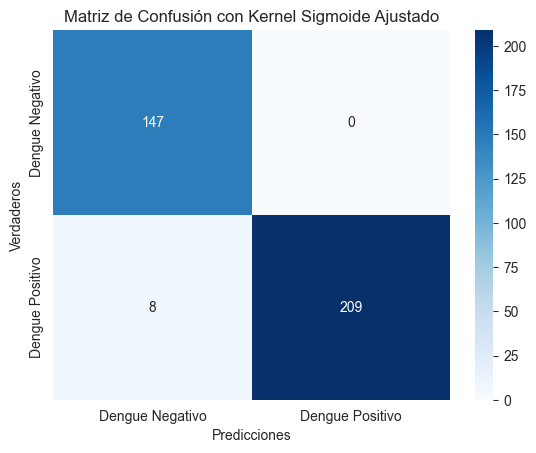

In [46]:
# Seleccionar las columnas numéricas
columnas_numericas = ['dias_con_fiebre', 'temperatura_actual', 'globulos_blancos',
                       'hemoglobina', 'hematocrito', 'plaquetas']

# Seleccionar las columnas no numéricas
columnas_no_numericas = ['dolor_cabeza_severo', 'dolor_detras_ojos', 'dolor_articular_muscular',
                          'sabor_metalico_boca', 'perdida_apetito', 'dolor_abdominal',
                          'nauseas_vomitos', 'diarrea']

# Estandarización de las columnas numéricas
scaler = StandardScaler()
df[columnas_numericas] = scaler.fit_transform(df[columnas_numericas])  # Solo estandariza las columnas numéricas

# X contiene solo las variables seleccionadas
X = df[columnas_no_numericas + ['dias_con_fiebre']]  # Agregamos 'dias_con_fiebre' junto con las no numéricas
y = df['dengue']  # Variable objetivo: dengue

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir los parámetros a ajustar para el modelo Sigmoide
param_grid_sigmoid = {
    'C': [0.1, 1, 10, 100],  # Parámetro de regularización
    'gamma': ['scale', 'auto']  # Parámetro gamma para el kernel sigmoide
}

# Crear el modelo SVM
svm_sigmoid = SVC(probability=True)

# Realizar búsqueda en cuadrícula para el modelo ajustado
grid_search_sigmoid = GridSearchCV(svm_sigmoid, param_grid_sigmoid, cv=5, scoring='accuracy')
grid_search_sigmoid.fit(X_train, y_train)

# Mejor parámetro
print(f"Mejores parámetros (Kernel Sigmoide): {grid_search_sigmoid.best_params_}")
best_svm_sigmoid = grid_search_sigmoid.best_estimator_

# Hacer predicciones con el modelo ajustado
y_pred_sigmoid_adjusted = best_svm_sigmoid.predict(X_test)

# Evaluar el modelo ajustado
print("Resultados con Kernel Sigmoide Ajustado")
# 1. Precisión (Accuracy)
accuracy_sigmoid_adjusted = accuracy_score(y_test, y_pred_sigmoid_adjusted)
print(f"Accuracy: {accuracy_sigmoid_adjusted:.4f}")

# 2. AUC-ROC
y_prob_sigmoid_adjusted = best_svm_sigmoid.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva
fpr_sigmoid_adjusted, tpr_sigmoid_adjusted, thresholds_sigmoid_adjusted = roc_curve(y_test, y_prob_sigmoid_adjusted)
roc_auc_sigmoid_adjusted = auc(fpr_sigmoid_adjusted, tpr_sigmoid_adjusted)
print(f"AUC-ROC: {roc_auc_sigmoid_adjusted:.4f}")

# 3. Sensibilidad (Recall)
recall_sigmoid_adjusted = recall_score(y_test, y_pred_sigmoid_adjusted)
print(f"Recall (Sensibilidad): {recall_sigmoid_adjusted:.4f}")

# 4. Tiempo de predicción
start_time_sigmoid = time.time()
y_pred_sigmoid_adjusted = best_svm_sigmoid.predict(X_test)
end_time_sigmoid = time.time()
prediction_time_sigmoid_adjusted = end_time_sigmoid - start_time_sigmoid
print(f"Tiempo de predicción: {prediction_time_sigmoid_adjusted:.4f} segundos")

# 5. Especificidad (Specificity)
cm_sigmoid_adjusted = confusion_matrix(y_test, y_pred_sigmoid_adjusted)
tn_sigmoid_adjusted, fp_sigmoid_adjusted, fn_sigmoid_adjusted, tp_sigmoid_adjusted = cm_sigmoid_adjusted.ravel()
specificity_sigmoid_adjusted = tn_sigmoid_adjusted / (tn_sigmoid_adjusted + fp_sigmoid_adjusted)
print(f"Especificidad: {specificity_sigmoid_adjusted:.4f}")

# 6. Tasa de Falsos Positivos (FPR)
fpr_sigmoid_adjusted = fp_sigmoid_adjusted / (tn_sigmoid_adjusted + fp_sigmoid_adjusted)
print(f"Tasa de Falsos Positivos (FPR): {fpr_sigmoid_adjusted:.4f}")

# 7. F1-Score
f1_sigmoid_adjusted = f1_score(y_test, y_pred_sigmoid_adjusted)
print(f"F1-Score: {f1_sigmoid_adjusted:.4f}")

# Crear la matriz de confusión
cm_sigmoid_adjusted = confusion_matrix(y_test, y_pred_sigmoid_adjusted)

# Graficar la matriz de confusión ajustada
sns.heatmap(cm_sigmoid_adjusted, annot=True, fmt='d', cmap='Blues', xticklabels=['Dengue Negativo', 'Dengue Positivo'], yticklabels=['Dengue Negativo', 'Dengue Positivo'])
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')
plt.title('Matriz de Confusión con Kernel Sigmoide Ajustado')
plt.show()

# GRAFICOS PARAMETROS SIN AJUSTAR VS AJUSTADOS

 # PRECISION

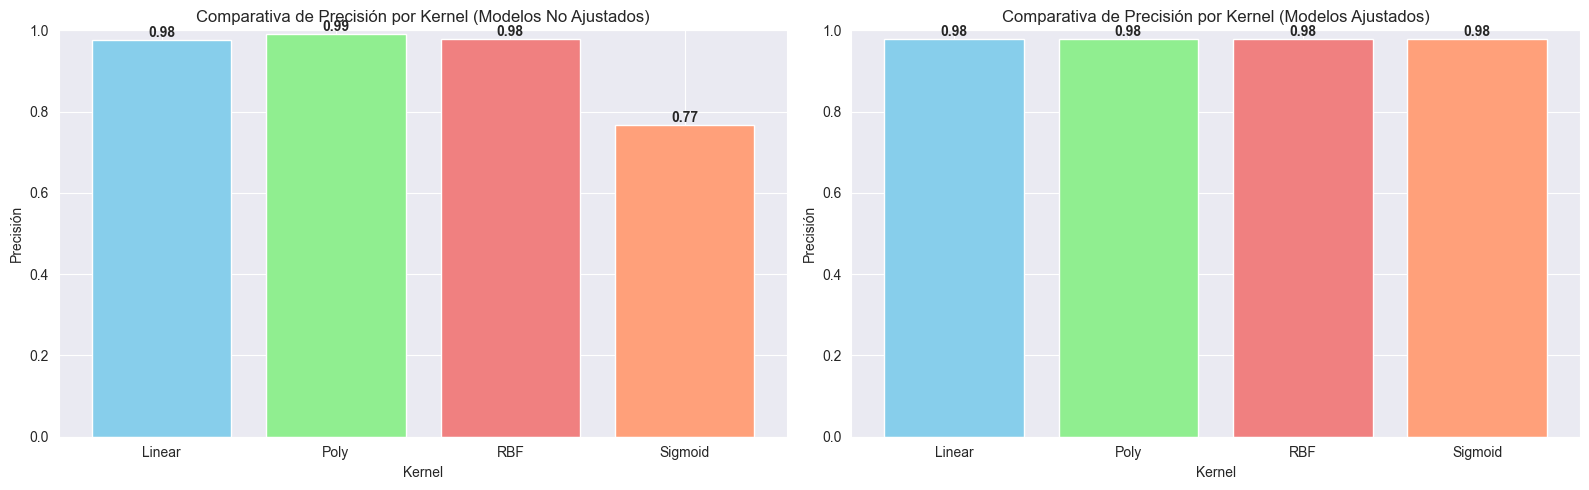

In [47]:
# Datos de precisión (accuracy) para modelos ajustados y no ajustados
accuracy_scores_adjusted = [accuracy_linear_adjusted, accuracy_poly_adjusted, accuracy_rbf_adjusted, accuracy_sigmoid_adjusted]
accuracy_scores = [accuracy_linear, accuracy_poly, accuracy_rbf, accuracy_sigmoid]
kernels = ['Linear', 'Poly', 'RBF', 'Sigmoid']

# Crear una figura con 2 subgráficos (uno al lado del otro)
plt.figure(figsize=(16, 5))

# Gráfico de barras para modelos no ajustados
plt.subplot(1, 2, 1)
bars = plt.bar(kernels, accuracy_scores, color=['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon'])
plt.title('Comparativa de Precisión por Kernel (Modelos No Ajustados)')
plt.xlabel('Kernel')
plt.ylabel('Precisión')
plt.ylim([0, 1])

# Añadir los valores sobre cada barra (no ajustados)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0, f'{yval:.2f}', ha='center', va='bottom', fontweight='bold')

    # Gráfico de barras para modelos ajustados (SVM con parámetros ajustados)
plt.subplot(1, 2, 2)
bars = plt.bar(kernels, accuracy_scores_adjusted, color=['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon'])
plt.title('Comparativa de Precisión por Kernel (Modelos Ajustados)')
plt.xlabel('Kernel')
plt.ylabel('Precisión')
plt.ylim([0, 1])

# Añadir los valores sobre cada barra (ajustados)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0, f'{yval:.2f}', ha='center', va='bottom', fontweight='bold')

# Mostrar los gráficos
plt.tight_layout()
plt.show()


# Tasa de Falsos Positivos (FPR)

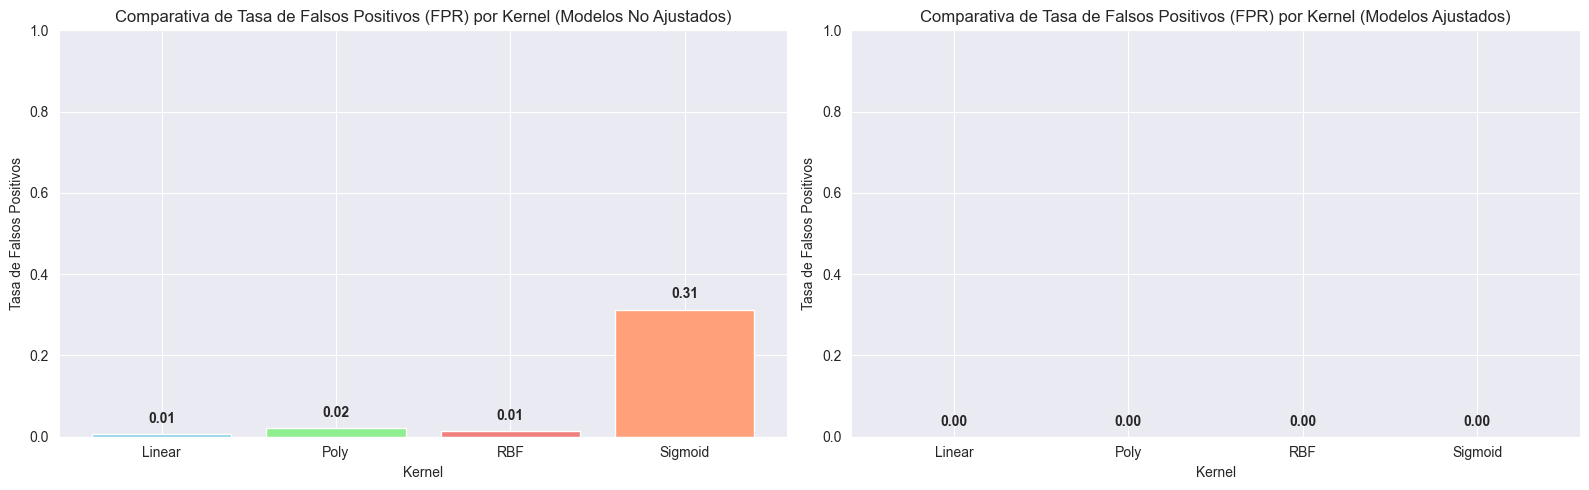

In [48]:
# Datos de Tasa de Falsos Positivos (FPR) para modelos ajustados y no ajustados
fpr_scores_adjusted = [fpr_linear_adjusted, fpr_poly_adjusted, fpr_rbf_adjusted, fpr_sigmoid_adjusted]
fpr_scores = [fpr_linear, fpr_poly, fpr_rbf, fpr_sigmoid]
kernels = ['Linear', 'Poly', 'RBF', 'Sigmoid']

# Crear una figura con 2 subgráficos (uno al lado del otro)
plt.figure(figsize=(16, 5))

# Gráfico de barras para modelos no ajustados
plt.subplot(1, 2, 1)
bars = plt.bar(kernels, fpr_scores, color=['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon'])
plt.title('Comparativa de Tasa de Falsos Positivos (FPR) por Kernel (Modelos No Ajustados)')
plt.xlabel('Kernel')
plt.ylabel('Tasa de Falsos Positivos')
plt.ylim([0, 1])  # Limitar el eje y para que se vea bien

# Añadir los valores sobre cada barra (no ajustados)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom', fontweight='bold')

# Gráfico de barras para modelos ajustados
plt.subplot(1, 2, 2)
bars = plt.bar(kernels, fpr_scores_adjusted, color=['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon'])
plt.title('Comparativa de Tasa de Falsos Positivos (FPR) por Kernel (Modelos Ajustados)')
plt.xlabel('Kernel')
plt.ylabel('Tasa de Falsos Positivos')
plt.ylim([0, 1])  # Limitar el eje y para que se vea bien

# Añadir los valores sobre cada barra (ajustados)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom', fontweight='bold')

# Mostrar los gráficos
plt.tight_layout()
plt.show()


# SENSIBILIDAD (RECALL)

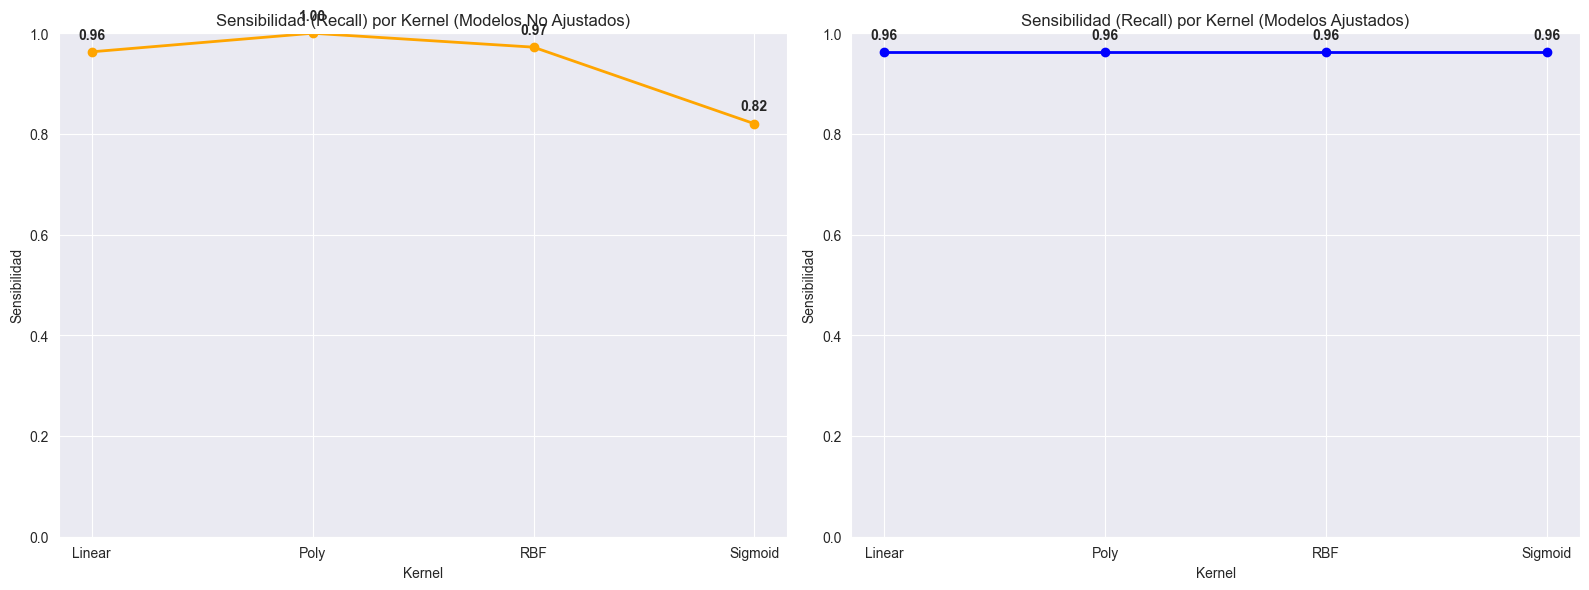

In [49]:
# Sensibilidad (Recall) para modelos ajustados y no ajustados
recall_scores_adjusted = [recall_linear_adjusted, recall_poly_adjusted, recall_rbf_adjusted, recall_sigmoid_adjusted]
recall_scores = [recall_linear, recall_poly, recall_rbf, recall_sigmoid]
kernels = ['Linear', 'Poly', 'RBF', 'Sigmoid']

# Crear una figura con 2 subgráficos (uno al lado del otro)
plt.figure(figsize=(16, 6))

# Gráfico de líneas para modelos no ajustados
plt.subplot(1, 2, 1)
plt.plot(kernels, recall_scores, marker='o', color='orange', linestyle='-', linewidth=2)
plt.title('Sensibilidad (Recall) por Kernel (Modelos No Ajustados)')
plt.xlabel('Kernel')
plt.ylabel('Sensibilidad')
plt.ylim([0, 1])  # Limitar el eje y para que se vea bien
plt.grid(True)

# Añadir los valores sobre cada punto de la línea (no ajustados)
for i, txt in enumerate(recall_scores):
    plt.text(kernels[i], recall_scores[i] + 0.02, f'{txt:.2f}', ha='center', va='bottom', fontweight='bold')

# Gráfico de líneas para modelos ajustados
plt.subplot(1, 2, 2)
plt.plot(kernels, recall_scores_adjusted, marker='o', color='blue', linestyle='-', linewidth=2)
plt.title('Sensibilidad (Recall) por Kernel (Modelos Ajustados)')
plt.xlabel('Kernel')
plt.ylabel('Sensibilidad')
plt.ylim([0, 1])  # Limitar el eje y para que se vea bien
plt.grid(True)

# Añadir los valores sobre cada punto de la línea (ajustados)
for i, txt in enumerate(recall_scores_adjusted):
    plt.text(kernels[i], recall_scores_adjusted[i] + 0.02, f'{txt:.2f}', ha='center', va='bottom', fontweight='bold')

# Mostrar los gráficos
plt.tight_layout()
plt.show()


# Tiempo de predicción

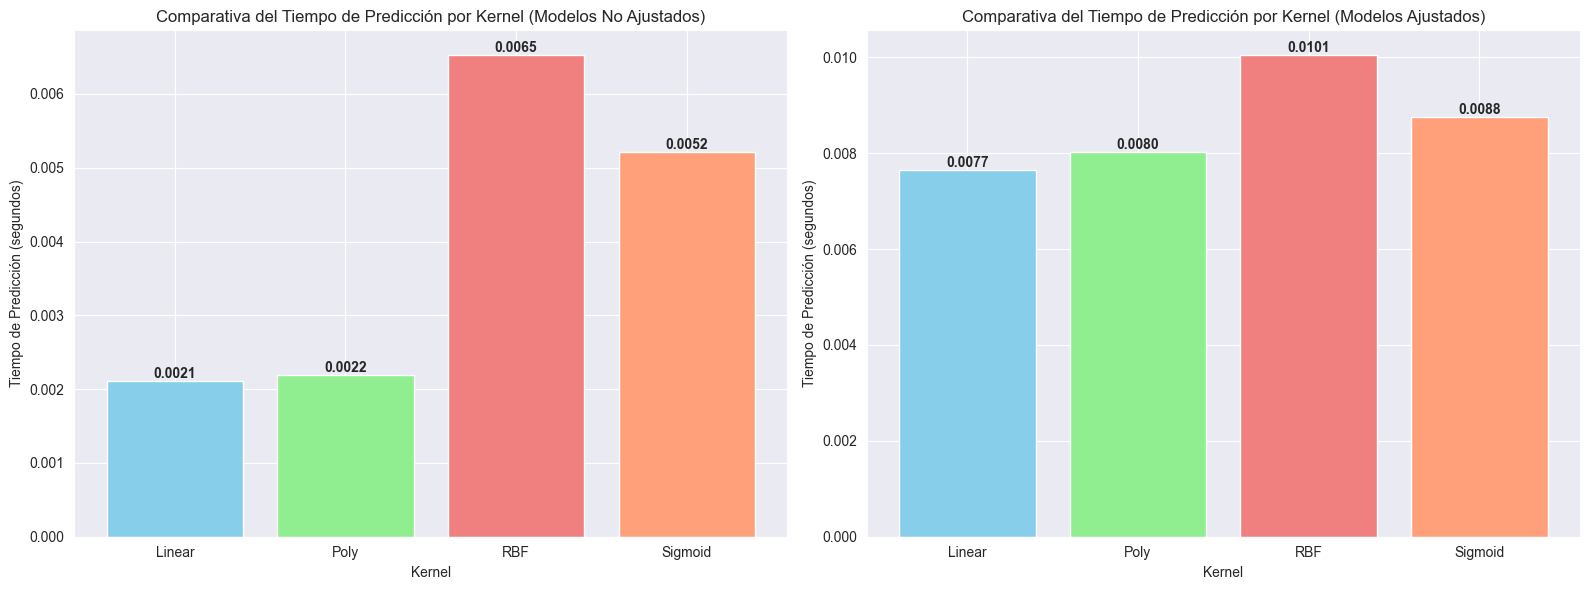

In [50]:
# Tiempo de predicción para modelos ajustados y no ajustados
prediction_times_adjusted = [prediction_time_linear_adjusted, prediction_time_poly_adjusted, prediction_time_rbf_adjusted, prediction_time_sigmoid_adjusted]
prediction_times = [prediction_time_linear, prediction_time_poly, prediction_time_rbf, prediction_time_sigmoid]
kernels = ['Linear', 'Poly', 'RBF', 'Sigmoid']

# Crear una figura con 2 subgráficos (uno al lado del otro)
plt.figure(figsize=(16, 6))

# Gráfico de barras para modelos no ajustados
plt.subplot(1, 2, 1)
bars = plt.bar(kernels, prediction_times, color=['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon'])
plt.title('Comparativa del Tiempo de Predicción por Kernel (Modelos No Ajustados)')
plt.xlabel('Kernel')
plt.ylabel('Tiempo de Predicción (segundos)')

# Añadir los valores sobre cada barra (no ajustados)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0, f'{yval:.4f}', ha='center', va='bottom', fontweight='bold')

# Gráfico de barras para modelos ajustados
plt.subplot(1, 2, 2)
bars = plt.bar(kernels, prediction_times_adjusted, color=['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon'])
plt.title('Comparativa del Tiempo de Predicción por Kernel (Modelos Ajustados)')
plt.xlabel('Kernel')
plt.ylabel('Tiempo de Predicción (segundos)')

# Añadir los valores sobre cada barra (ajustados)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0, f'{yval:.4f}', ha='center', va='bottom', fontweight='bold')

# Mostrar los gráficos
plt.tight_layout()
plt.show()


# F1-Score

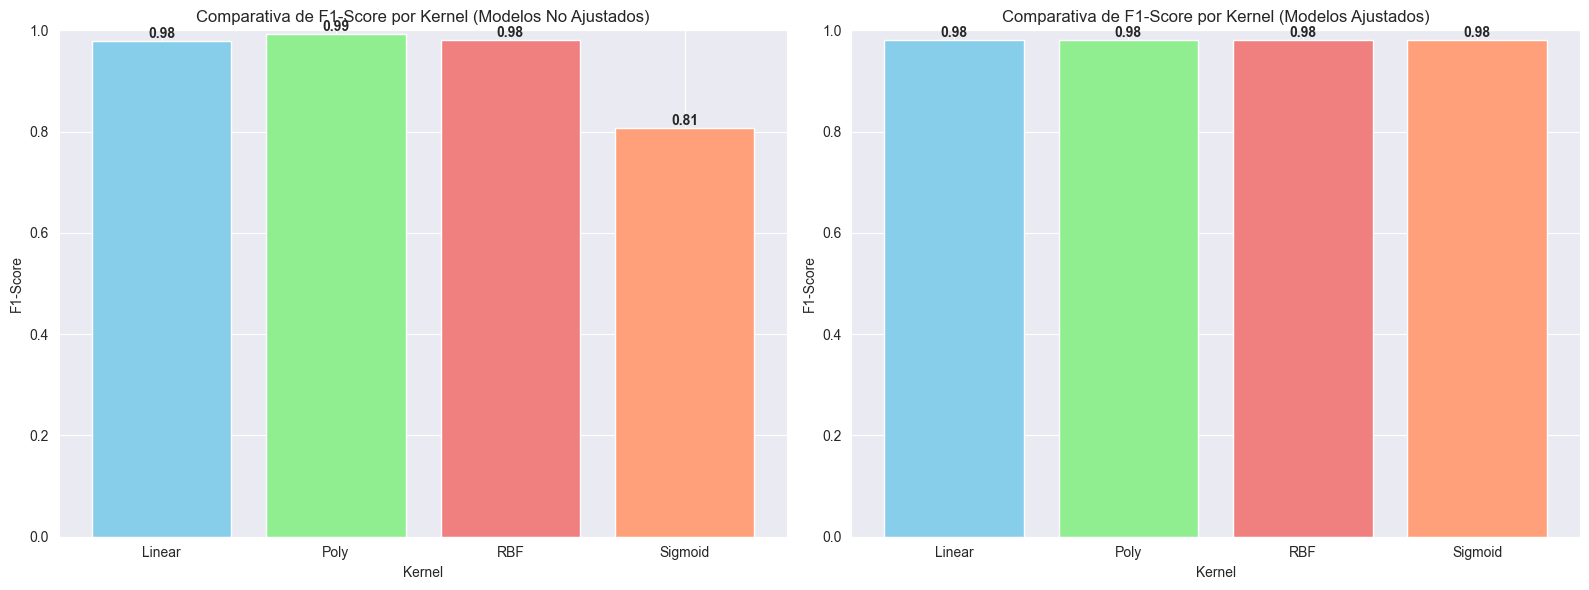

In [51]:
# F1-Score para modelos ajustados y no ajustados
f1_scores_adjusted = [f1_linear_adjusted, f1_poly_adjusted, f1_rbf_adjusted, f1_sigmoid_adjusted]
f1_scores = [f1_linear, f1_poly, f1_rbf, f1_sigmoid]
kernels = ['Linear', 'Poly', 'RBF', 'Sigmoid']

# Crear una figura con 2 subgráficos (uno al lado del otro)
plt.figure(figsize=(16, 6))

# Gráfico de barras para modelos no ajustados
plt.subplot(1, 2, 1)
bars = plt.bar(kernels, f1_scores, color=['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon'])
plt.title('Comparativa de F1-Score por Kernel (Modelos No Ajustados)')
plt.xlabel('Kernel')
plt.ylabel('F1-Score')
plt.ylim([0, 1])  # Limitar el eje y para que se vea bien

# Añadir los valores sobre cada barra (no ajustados)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0, f'{yval:.2f}', ha='center', va='bottom', fontweight='bold')

# Gráfico de barras para modelos ajustados
plt.subplot(1, 2, 2)
bars = plt.bar(kernels, f1_scores_adjusted, color=['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon'])
plt.title('Comparativa de F1-Score por Kernel (Modelos Ajustados)')
plt.xlabel('Kernel')
plt.ylabel('F1-Score')
plt.ylim([0, 1])  # Limitar el eje y para que se vea bien

# Añadir los valores sobre cada barra (ajustados)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0, f'{yval:.2f}', ha='center', va='bottom', fontweight='bold')

# Mostrar los gráficos
plt.tight_layout()
plt.show()


# AUC-ROC

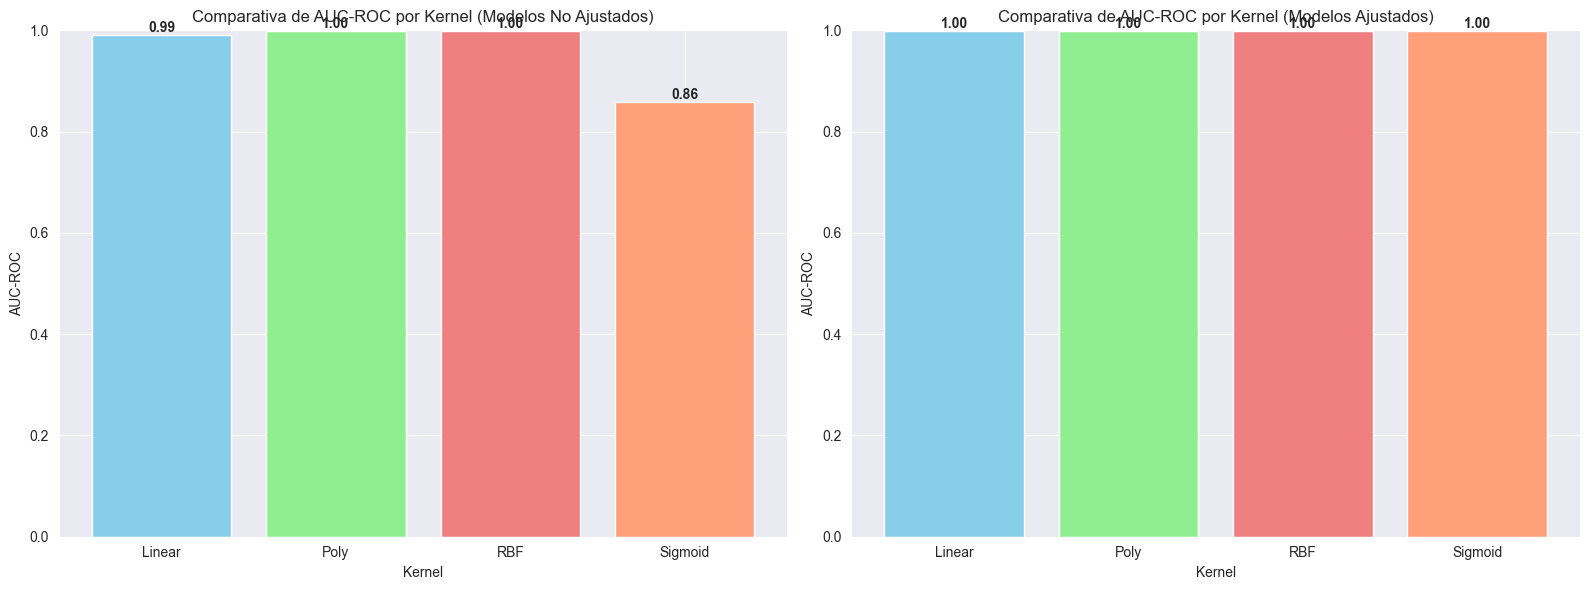

In [52]:
# AUC-ROC para modelos ajustados y no ajustados
roc_auc_scores_adjusted = [roc_auc_linear_adjusted, roc_auc_poly_adjusted, roc_auc_rbf_adjusted, roc_auc_sigmoid_adjusted]
roc_auc_scores = [roc_auc_linear, roc_auc_poly, roc_auc_rbf, roc_auc_sigmoid]
kernels = ['Linear', 'Poly', 'RBF', 'Sigmoid']

# Crear una figura con 2 subgráficos (uno al lado del otro)
plt.figure(figsize=(16, 6))

# Gráfico de barras para modelos no ajustados
plt.subplot(1, 2, 1)
bars = plt.bar(kernels, roc_auc_scores, color=['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon'])
plt.title('Comparativa de AUC-ROC por Kernel (Modelos No Ajustados)')
plt.xlabel('Kernel')
plt.ylabel('AUC-ROC')
plt.ylim([0, 1])  # Limitar el eje y para que se vea bien

# Añadir los valores sobre cada barra (no ajustados)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0, f'{yval:.2f}', ha='center', va='bottom', fontweight='bold')

# Gráfico de barras para modelos ajustados
plt.subplot(1, 2, 2)
bars = plt.bar(kernels, roc_auc_scores_adjusted, color=['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon'])
plt.title('Comparativa de AUC-ROC por Kernel (Modelos Ajustados)')
plt.xlabel('Kernel')
plt.ylabel('AUC-ROC')
plt.ylim([0, 1])  # Limitar el eje y para que se vea bien

# Añadir los valores sobre cada barra (ajustados)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0, f'{yval:.2f}', ha='center', va='bottom', fontweight='bold')

# Mostrar los gráficos
plt.tight_layout()
plt.show()
